In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

[*********************100%%**********************]  1 of 1 completed

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

3/3 [==============================] - 1s 71ms/step

3/3 [==============================] - 1s 71ms/step

3/3 [==============================] - 1s 65ms/step

3/3 [==============================] - 1s 62ms/step

3/3 [==============================] - 1s 63ms/step

3/3 [==============================] - 1s 62ms/step

3/3 [==============================] - 2s 65ms/step

3/3 [==============================] - 1s 63ms/step

3/3 [==============================] - 1s 68ms/step

3/3 [==============================] - 1s 65ms/step

3/3 [==============================] - 1s 65ms/step

3/3 [==============================] - 2s 127ms/step

3/3 [==============================] - 2s 108ms/step

3/3 [==============================] - 1s 110ms/step

3/3 [==============================] - 1s 72ms/step

3/3 [==============================] - 1s 72ms/step

3/3 [==============================] - 1s 67ms/step

3/3 [==============================] - 1s 94ms/step

3/3 [==============================] - 2s 6

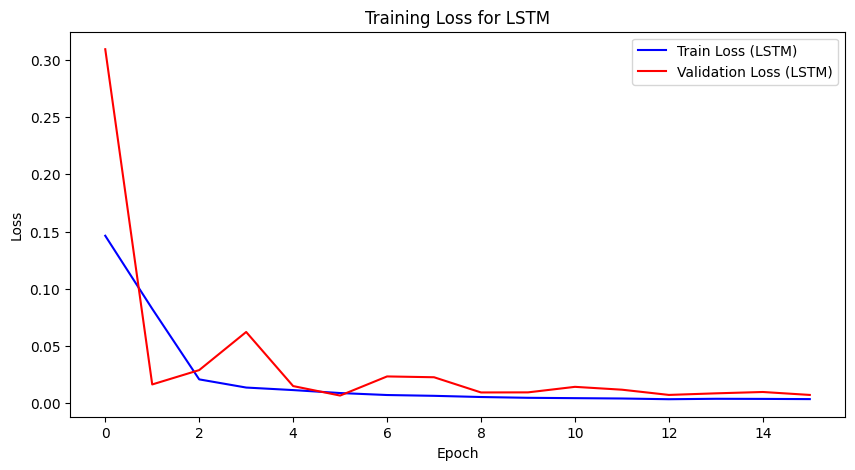

<Figure size 1000x500 with 0 Axes>

In [ ]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import mean_squared_error
import math
from hyperopt import fmin, tpe, hp, space_eval, Trials
from tensorflow.keras.callbacks import EarlyStopping
from pyngrok import ngrok
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Streamlit app
def main():
    st.title("Stock Price Prediction App")

    # Download stock price data
    st.sidebar.header("Data Download")
    stock_symbol = st.sidebar.text_input("Enter Stock Symbol (e.g., BBCA.JK):", "BBCA.JK")
    start_date = st.sidebar.date_input("Start Date", pd.to_datetime("2021-01-01"))
    end_date = st.sidebar.date_input("End Date", pd.to_datetime("2023-01-01"))

    data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Data preprocessing
    close_prices = data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)

    # Data preparation
    n_steps = st.sidebar.slider("Select Number of Time Steps:", min_value=10, max_value=300, value=120, step=10)
    X, y = prepare_data(scaled_data, n_steps)

    # Splitting into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape data for LSTM and GRU models
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Sidebar for hyperparameter tuning
    st.sidebar.header("Hyperparameter Tuning")
    units = st.sidebar.selectbox("Select Number of Units:", [50, 100, 150], index=1)
    dropout_rate = st.sidebar.slider("Select Dropout Rate:", min_value=0.2, max_value=0.5, value=0.4, step=0.01)
    learning_rate = st.sidebar.slider("Select Learning Rate:", np.log(0.001), np.log(0.01), value=np.log(0.005), step=0.001)
    epochs = st.sidebar.selectbox("Select Number of Epochs:", [50, 100, 150], index=1)
    batch_size = st.sidebar.selectbox("Select Batch Size:", [32, 64, 128], index=1)

    # Hyperparameter search space
    space = {
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': np.exp(learning_rate),
        'epochs': epochs,
        'batch_size': batch_size
    }

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Run hyperparameter optimization
    best_params_lstm, history_lstm, y_pred_lstm, y_test_orig_lstm = run_optimization(space, 'lstm', X_train_lstm, y_train, X_test_lstm, y_test, scaler, early_stopping)
    best_params_gru, history_gru, y_pred_gru, y_test_orig_gru = run_optimization(space, 'gru', X_train_gru, y_train, X_test_gru, y_test, scaler, early_stopping)

    # Display results
    st.header("Results for LSTM Model")
    display_results(best_params_lstm, history_lstm, y_test_orig_lstm, y_pred_lstm)

    st.header("Results for GRU Model")
    display_results(best_params_gru, history_gru, y_test_orig_gru, y_pred_gru)

    # Visualize predictions for the final LSTM model
    st.header("Visualize Predictions (LSTM)")
    visualize_predictions(data, train_size, n_steps, y_test_orig_lstm, y_pred_lstm)

    # Visualize predictions for the final GRU model
    st.header("Visualize Predictions (GRU)")
    visualize_predictions(data, train_size, n_steps, y_test_orig_gru, y_pred_gru)

    # Plot training history using Matplotlib
    st.header("Training History")
    plot_training_history(history_lstm, history_gru)


def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        lag_values = data[i:(i + n_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + n_steps, 0]]]))
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)


def run_optimization(space, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping):
    # Set up the Trials object to keep track of the optimization process
    trials = Trials()

    # Use the fmin function for Bayesian optimization
    best_params = fmin(fn=lambda params: objective(params, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping),
                      space=space, algo=tpe.suggest, max_evals=20, trials=trials)

    # Get the best hyperparameters from the optimization results
    best_params = space_eval(space, best_params)

    # Build the final model using the best hyperparameters
    final_model = build_model(best_params, model_type, X_train)

    # Train the final model
    history = final_model.fit(X_train, y_train,
                              epochs=best_params['epochs'],
                              batch_size=best_params['batch_size'],
                              verbose=2,
                              validation_split=0.1,
                              callbacks=[early_stopping])

    # Model evaluation
    y_pred = final_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    return best_params, history, y_pred, y_test_orig


def build_model(params, model_type, X_train):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))
    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')
    return model


def objective(params, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping):
    # Build and train the model
    final_model = build_model(params, model_type, X_train)
    history = final_model.fit(X_train, y_train,
                              epochs=params['epochs'],
                              batch_size=params['batch_size'],
                              verbose=0,
                              validation_split=0.1,
                              callbacks=[early_stopping])

    # Model evaluation
    y_pred = final_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate and return mean squared error
    mse = mean_squared_error(y_test_orig, y_pred)
    return mse


def display_results(best_params, history, y_test_orig, y_pred):
    mse = mean_squared_error(y_test_orig, y_pred)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100

    st.write("Best Hyperparameters:", best_params)
    st.write("Mean Squared Error (MSE):", mse)
    st.write("Root Mean Squared Error (RMSE):", rmse)
    st.write("Mean Absolute Percentage Error (MAPE):", mape)

    # Plot training loss
    st.line_chart(pd.DataFrame({'Train Loss': history.history['loss'], 'Validation Loss': history.history['val_loss']}))


def visualize_predictions(data, train_size, n_steps, y_test_orig, y_pred):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                             y=y_test_orig.flatten(),
                             mode='lines',
                             name="Actual Stock Prices",
                             line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                             y=y_pred.flatten(),
                             mode='lines',
                             name="Predicted Stock Prices",
                             line=dict(color='red')))

    fig.update_layout(title="Stock Price Prediction",
                      xaxis_title="Date",
                      yaxis_title="Stock Price (IDR)",
                      template='plotly_dark')

    st.plotly_chart(fig)


def plot_training_history(history_lstm, history_gru):

    # Plot training loss for LSTM
    st.subheader("Training Loss for LSTM")
    plt.figure(figsize=(10, 5))
    plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
    plt.title('Training Loss for LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training loss for GRU
    st.subheader("Training Loss for GRU")
    plt.figure(figsize=(10, 5))
    plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
    plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
    plt.title('Training Loss for GRU')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    st.pyplot()

if __name__ == "__main__":
    main()

In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.483s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [3]:
!streamlit run app.py &>/content/logs.txt &

In [4]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.106.29.243


In [ ]:
! streamlit run forecasting_streamlit.py & npx localtunnel --port 8501

[##................] | loadDep:strip-ansi: sill resolveWithNewModule wrap-ansi@


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8502
  External URL: http://34.106.29.243:8502

npx: installed 22 in 5.563s
your url is: https://real-knives-peel.loca.lt
